In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.path import Path
import os

plt.rcParams["figure.figsize"] = (6, 5)

In [ ]:
def half_normal(d, sd):
    """Half-normal detection function."""
    return np.exp(-d**2 / (2 * sd**2))

In [ ]:
def make_array(geometry='square', spacing=5.0, offset=4.0):
    """Return x, y coordinates for a given array geometry."""
    if geometry == 'square':
        xs = np.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5]) * spacing
        ys = np.array([0, 0, 0, 0, 1, 1, 1, 1]) * spacing + offset
    elif geometry == 'triangular':
        xs = np.array([-spacing, 0, spacing, -spacing/2, spacing/2, -spacing, 0, spacing])
        ys = np.array([0, 0, 0, np.sqrt(3)/2*spacing, np.sqrt(3)/2*spacing,
                       np.sqrt(3)*spacing, np.sqrt(3)*spacing, np.sqrt(3)*spacing]) + offset
    elif geometry == 'line':
        xs = np.linspace(-3.5, 3.5, 8) * spacing
        ys = np.ones(8) * offset
    else:
        raise ValueError("Unsupported geometry type.")
    return xs, ys

In [ ]:
def compute_distances(xs, ys, grid_x, grid_y):
    """Compute distances from each hydrophone to each grid point."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    return np.sqrt((gx[None, :, :] - xs[:, None, None])**2 +
                   (gy[None, :, :] - ys[:, None, None])**2)

def calculate_probs(det_func, distances):
    """Calculate detection probabilities for each unit."""
    return det_func(distances)

In [ ]:
def detection_probabilities(probs):
    """Compute joint detection probabilities for 4+ units detecting."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)
    one_det = np.zeros((nx, ny))
    two_det = np.zeros((nx, ny))
    three_det = np.zeros((nx, ny))

    for i in range(num_units):
        one_det += probs[i] * np.prod(1 - np.delete(probs, i, 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            two_det += probs[i] * probs[j] * np.prod(1 - np.delete(probs, [i, j], 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            for k in range(j+1, num_units):
                three_det += probs[i] * probs[j] * probs[k] * np.prod(1 - np.delete(probs, [i, j, k], 0), axis=0)

    four_plus = 1 - no_det - one_det - two_det - three_det
    return four_plus

def detection_probabilities_single(probs):
    """Compute joint detection probabilities for 1+ units detecting."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)
    one_plus = 1 - no_det
    return one_plus

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.path import Path
import os

plt.rcParams["figure.figsize"] = (6, 5)

# ============================================================================
# Detection Function
# ============================================================================

def half_normal(d, sd):
    """Half-normal detection function."""
    return np.exp(-d**2 / (2 * sd**2))

# ============================================================================
# Array Geometries (for comparison with GA)
# ============================================================================

def make_array(geometry='square', spacing=5.0, offset=4.0):
    """Return x, y coordinates for a given array geometry."""
    if geometry == 'square':
        xs = np.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5]) * spacing
        ys = np.array([0, 0, 0, 0, 1, 1, 1, 1]) * spacing + offset
    elif geometry == 'triangular':
        xs = np.array([-spacing, 0, spacing, -spacing/2, spacing/2, -spacing, 0, spacing])
        ys = np.array([0, 0, 0, np.sqrt(3)/2*spacing, np.sqrt(3)/2*spacing,
                       np.sqrt(3)*spacing, np.sqrt(3)*spacing, np.sqrt(3)*spacing]) + offset
    elif geometry == 'line':
        xs = np.linspace(-3.5, 3.5, 8) * spacing
        ys = np.ones(8) * offset
    else:
        raise ValueError("Unsupported geometry type.")
    return xs, ys

# ============================================================================
# Distance and Probability Computations
# ============================================================================

def compute_distances(xs, ys, grid_x, grid_y):
    """Compute distances from each hydrophone to each grid point."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    return np.sqrt((gx[None, :, :] - xs[:, None, None])**2 +
                   (gy[None, :, :] - ys[:, None, None])**2)

def calculate_probs(det_func, distances):
    """Calculate detection probabilities for each unit."""
    return det_func(distances)

# ============================================================================
# Combine Detection Probabilities
# ============================================================================

def detection_probabilities(probs):
    """Compute joint detection probabilities for 4+ units detecting."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)
    one_det = np.zeros((nx, ny))
    two_det = np.zeros((nx, ny))
    three_det = np.zeros((nx, ny))

    for i in range(num_units):
        one_det += probs[i] * np.prod(1 - np.delete(probs, i, 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            two_det += probs[i] * probs[j] * np.prod(1 - np.delete(probs, [i, j], 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            for k in range(j+1, num_units):
                three_det += probs[i] * probs[j] * probs[k] * np.prod(1 - np.delete(probs, [i, j, k], 0), axis=0)

    four_plus = 1 - no_det - one_det - two_det - three_det
    return four_plus

def detection_probabilities_single(probs):
    """Compute joint detection probabilities for 1+ units detecting."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)
    one_plus = 1 - no_det
    return one_plus

# ============================================================================
# Mask Functions
# ============================================================================

def semicircle_mask(grid_x, grid_y, radius, center=(0, 0), upper_half=True):
    """Return a boolean mask for points inside a semi-circle."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist = np.sqrt((gx - center[0])**2 + (gy - center[1])**2)
    mask = dist <= radius
    if upper_half:
        mask &= gy >= center[1]
    return mask

def circle_mask(grid_x, grid_y, radius, center=(0, 0)):
    """Generate a full circle mask."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist_from_center = np.sqrt((gx - center[0])**2 + (gy - center[1])**2)
    return dist_from_center <= radius

def rectangle_mask(grid_x, grid_y, xmin, xmax, ymin, ymax):
    """Generate a rectangular mask."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    return (gx >= xmin) & (gx <= xmax) & (gy >= ymin) & (gy <= ymax)

def create_custom_shape_mask(grid_x, grid_y, vertices):
    """Create a mask from a polygon defined by vertices."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    points = np.vstack([gx.ravel(), gy.ravel()]).T
    path = Path(vertices)
    mask = path.contains_points(points).reshape(gx.shape)
    return mask

In [ ]:
def mean_probability_in_mask(prob_map, mask):
    """Compute mean probability inside the masked region."""
    if not np.any(mask):
        return 0.0
    return np.mean(prob_map[mask])

def min_probability_in_mask(prob_map, mask):
    """Compute minimum probability inside the masked region."""
    if not np.any(mask):
        return 0.0
    return np.min(prob_map[mask])

In [ ]:
class Individual:
    def __init__(self, num_recorders, bounds):
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.xs, self.ys = self.random_positions()
        self.fitness_value = None

    def random_positions(self):
        xmin, xmax, ymin, ymax = self.bounds
        xs = np.random.uniform(xmin, xmax, self.num_recorders)
        ys = np.random.uniform(ymin, ymax, self.num_recorders)
        return xs, ys

    def mutate(self, rate, std):
        xs_new, ys_new = self.xs.copy(), self.ys.copy()
        mask = np.random.rand(len(xs_new)) < rate
        xs_new[mask] += np.random.normal(0, std, np.sum(mask))
        ys_new[mask] += np.random.normal(0, std, np.sum(mask))
        xmin, xmax, ymin, ymax = self.bounds
        xs_new = np.clip(xs_new, xmin, xmax)
        ys_new = np.clip(ys_new, ymin, ymax)
        self.xs, self.ys = xs_new, ys_new

    @staticmethod
    def crossover(parent1, parent2):
        alpha = np.random.rand()
        xs = alpha * parent1.xs + (1 - alpha) * parent2.xs
        ys = alpha * parent1.ys + (1 - alpha) * parent2.ys
        child = Individual(parent1.num_recorders, parent1.bounds)
        child.xs, child.ys = xs, ys
        return child


In [ ]:
class Environment:
    def __init__(self, grid_x, grid_y, det_func, mask,
                 pop_size=30, generations=100, num_recorders=8, bounds=(-30, 30, 0, 30),
                 mutation_rate=0.2, mutation_std=1.5, metric='mean',
                 empty_penalty=True, close_penalty=True,
                 empty_penalty_fraction=0.3, close_penalty_fraction=0.2,
                 min_dist=3.0, alpha_curve='linear',
                 detection_probabilities_func=None,
                 detection_probabilities_helper_func=None):
        """
        Flexible GA environment that works with any mask shape.

        Parameters:
        -----------
        grid_x, grid_y : array-like
            Grid coordinates
        det_func : callable
            Detection function f(distance) -> probability
        mask : np.ndarray
            Boolean mask defining the region of interest
        detection_probabilities_func : callable
            Function to compute main detection probabilities (e.g., 4+ detections)
        detection_probabilities_helper_func : callable
            Helper function for progressive optimization (e.g., 1+ detections)
        alpha_curve : str
            'linear' or 'expo' - controls transition from helper to main objective
        """
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.det_func = det_func
        self.mask = mask

        self.pop_size = pop_size
        self.generations = generations
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.mutation_rate = mutation_rate
        self.mutation_std = mutation_std
        self.metric = metric

        self.empty_penalty = empty_penalty
        self.close_penalty = close_penalty
        self.empty_penalty_fraction = empty_penalty_fraction
        self.close_penalty_fraction = close_penalty_fraction
        self.min_dist = min_dist
        self.alpha_curve = alpha_curve

        # Detection probability functions
        self.detection_probabilities_func = detection_probabilities_func or detection_probabilities
        self.detection_probabilities_helper_func = detection_probabilities_helper_func or detection_probabilities_single

    def evaluate(self, individual, generation):
        """Evaluate fitness of an individual."""
        distances = compute_distances(individual.xs, individual.ys, self.grid_x, self.grid_y)
        probs = calculate_probs(self.det_func, distances)

        # Main objective (e.g., 4+ detections)
        prob_map = self.detection_probabilities_func(probs)
        # Helper objective (e.g., 1+ detections)
        prob_map_helper = self.detection_probabilities_helper_func(probs)

        # Calculate alpha (transition weight)
        if self.alpha_curve == 'linear':
            alpha = generation / self.generations
        elif self.alpha_curve == 'expo':
            alpha = 1 - np.exp(-4 * generation / self.generations)
        else:
            alpha = 1.0  # Default to main objective only

        # Calculate base score
        if self.metric == "mean":
            score_main = mean_probability_in_mask(prob_map, self.mask)
            score_helper = mean_probability_in_mask(prob_map_helper, self.mask)
        elif self.metric == "maxmin":
            score_main = min_probability_in_mask(prob_map, self.mask)
            score_helper = min_probability_in_mask(prob_map_helper, self.mask)
        else:
            score_main = mean_probability_in_mask(prob_map, self.mask)
            score_helper = mean_probability_in_mask(prob_map_helper, self.mask)

        # Progressive optimization: start with helper, transition to main
        score = alpha * score_main + (1 - alpha) * score_helper

        # Empty penalty: penalize low probability areas
        if self.empty_penalty:
            low_prob_area = np.mean(prob_map[self.mask] < 0.2) if np.any(self.mask) else 0
            score -= self.empty_penalty_fraction * low_prob_area

        # Close penalty: penalize recorders too close to each other
        if self.close_penalty:
            dists = np.sqrt((individual.xs[:, None] - individual.xs[None, :])**2 +
                            (individual.ys[:, None] - individual.ys[None, :])**2)
            np.fill_diagonal(dists, np.inf)
            too_close_fraction = np.mean(dists < self.min_dist)
            score -= self.close_penalty_fraction * too_close_fraction

        individual.fitness_value = score
        return score

    def select_parents(self, population):
        """Select top parents for reproduction."""
        population.sort(key=lambda ind: ind.fitness_value, reverse=True)
        return population[:5]

    def run(self, verbose=True, k_top=3, save_plots=False):
        """Run the genetic algorithm."""
        population = [Individual(self.num_recorders, self.bounds) for _ in range(self.pop_size)]
        best_scores = []

        if save_plots:
            os.makedirs("plots", exist_ok=True)

        for gen in range(self.generations):
            # Evaluate population
            for ind in population:
                self.evaluate(ind, gen)
            population.sort(key=lambda i: i.fitness_value, reverse=True)
            best = population[0]

            mean_fit = np.mean([i.fitness_value for i in population])
            best_scores.append(best.fitness_value)

            if verbose:
                print(f"Gen {gen+1:02d} | Mean={mean_fit:.4f} | Best={best.fitness_value:.4f}")

            # Save plots periodically
            if save_plots and (gen + 1) % 50 == 0:
                self.plot_top_k(population, k_top)
                plt.savefig(f"plots/gen_{gen+1:04d}.png", dpi=200)
                plt.close()

            # Reproduction
            parents = self.select_parents(population)
            new_population = [best]  # elitism
            while len(new_population) < self.pop_size:
                p1, p2 = random.sample(parents, 2)
                child = Individual.crossover(p1, p2)
                child.mutate(self.mutation_rate, self.mutation_std)
                new_population.append(child)

            population = new_population

        # Final evaluation
        for ind in population:
            self.evaluate(ind, self.generations)
        population.sort(key=lambda i: i.fitness_value, reverse=True)
        best_ind = population[0]
        self.plot_top_k(population, k_top)
        return best_ind, best_scores

    def plot_top_k(self, population, k):
        """Plot the top k solutions."""
        top = population[:k]
        fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))
        if k == 1:
            axes = [axes]

        for ax, ind in zip(axes, top):
            distances = compute_distances(ind.xs, ind.ys, self.grid_x, self.grid_y)
            probs = calculate_probs(self.det_func, distances)
            prob_map = self.detection_probabilities_func(probs)

            im = ax.pcolormesh(self.grid_x, self.grid_y, prob_map.T, cmap='magma',
                              shading='auto', vmin=0, vmax=1)
            ax.scatter(ind.xs, ind.ys, c='white', edgecolor='k', s=60)

            # Overlay the mask boundary
            ax.contour(self.grid_x, self.grid_y, self.mask.T, levels=[0.5],
                      colors='cyan', linewidths=2, linestyles='--')

            ax.set_aspect('equal', 'box')
            ax.set_title(f"Fit={ind.fitness_value:.3f}")
            ax.set_xlabel("X (km)")
            ax.set_ylabel("Y (km)")

        cbar = fig.colorbar(im, ax=axes[-1], fraction=0.046, pad=0.04)
        cbar.set_label("Detection Probability (4+ Units)")

        fig.suptitle(f"Top {k} GA Solutions", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [ ]:
def plot_probability_map(grid_x, grid_y, prob_map, array_xs, array_ys, mask, title="Detection Probability"):
    """Plot probability map with array configuration."""
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(grid_x, grid_y, prob_map.T, cmap='magma', shading='auto', vmin=0, vmax=1)
    plt.colorbar(label="Probability")
    plt.scatter(array_xs, array_ys, c='white', edgecolor='k', s=60, label="Hydrophones")

    # Draw mask boundary
    plt.contour(grid_x, grid_y, mask.T, levels=[0.5], colors='cyan', linewidths=2, linestyles='--', label="Region boundary")

    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.title(title)
    plt.legend()
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

COMPARISON: Fixed Array Geometries
[square] Mean probability (4+ units, r=20.0 km): 0.640


/tmp/ipython-input-585382035.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(grid_x, grid_y, mask.T, levels=[0.5], colors='cyan', linewidths=2, linestyles='--', label="Region boundary")


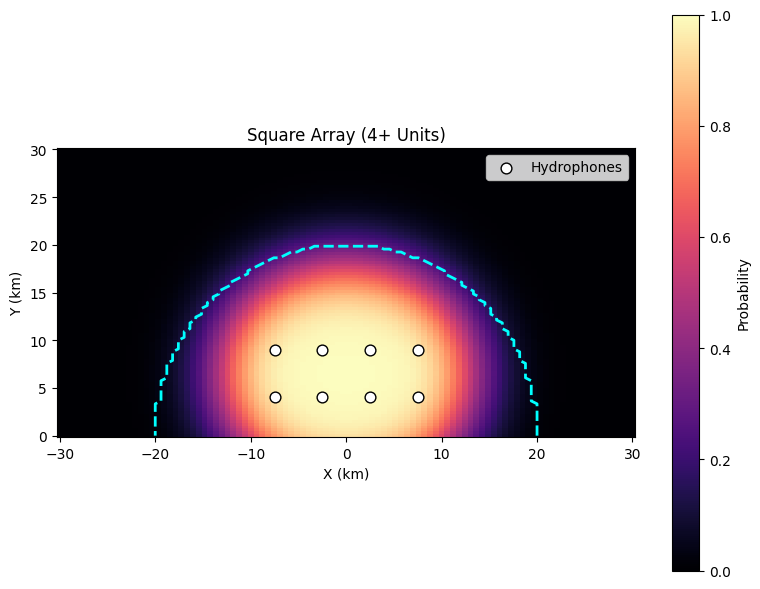

[triangular] Mean probability (4+ units, r=20.0 km): 0.654


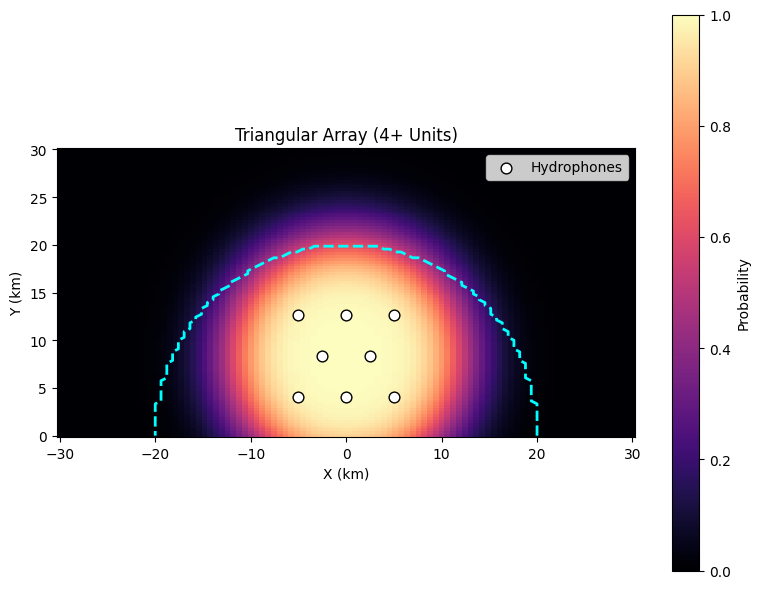

[line] Mean probability (4+ units, r=20.0 km): 0.482


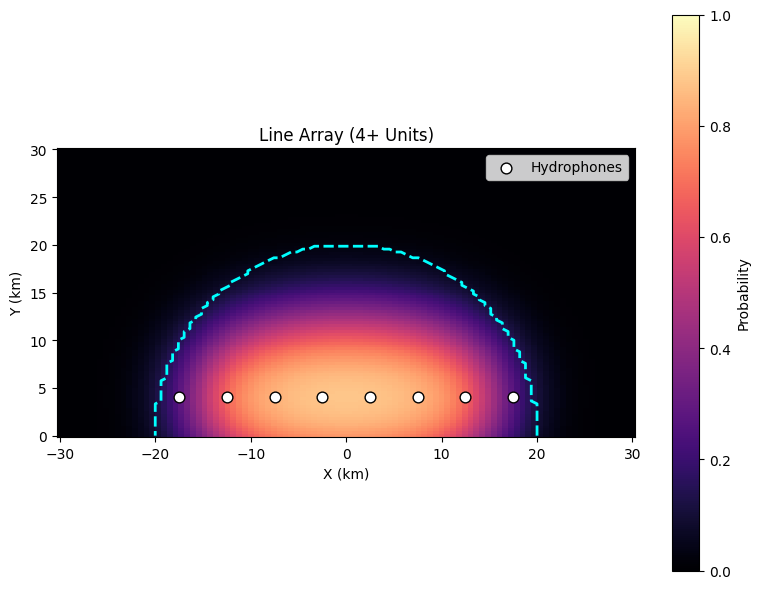


GENETIC ALGORITHM: Semicircle Mask (4+ Units)
Gen 01 | Mean=0.0843 | Best=0.5690
Gen 02 | Mean=0.5751 | Best=0.7602
Gen 03 | Mean=0.7299 | Best=0.7669
Gen 04 | Mean=0.7624 | Best=0.7792
Gen 05 | Mean=0.7671 | Best=0.7997
Gen 06 | Mean=0.7809 | Best=0.8117
Gen 07 | Mean=0.7937 | Best=0.8248
Gen 08 | Mean=0.8091 | Best=0.8337
Gen 09 | Mean=0.8158 | Best=0.8383
Gen 10 | Mean=0.8215 | Best=0.8402
Gen 11 | Mean=0.8242 | Best=0.8455
Gen 12 | Mean=0.8298 | Best=0.8420
Gen 13 | Mean=0.8299 | Best=0.8490
Gen 14 | Mean=0.8315 | Best=0.8521
Gen 15 | Mean=0.8406 | Best=0.8541
Gen 16 | Mean=0.8390 | Best=0.8516
Gen 17 | Mean=0.8385 | Best=0.8521
Gen 18 | Mean=0.8382 | Best=0.8522
Gen 19 | Mean=0.8312 | Best=0.8482
Gen 20 | Mean=0.8320 | Best=0.8522
Gen 21 | Mean=0.8318 | Best=0.8481
Gen 22 | Mean=0.8332 | Best=0.8440
Gen 23 | Mean=0.8278 | Best=0.8415
Gen 24 | Mean=0.8256 | Best=0.8373
Gen 25 | Mean=0.8188 | Best=0.8361
Gen 26 | Mean=0.8180 | Best=0.8437
Gen 27 | Mean=0.8169 | Best=0.8397
Gen 28 |

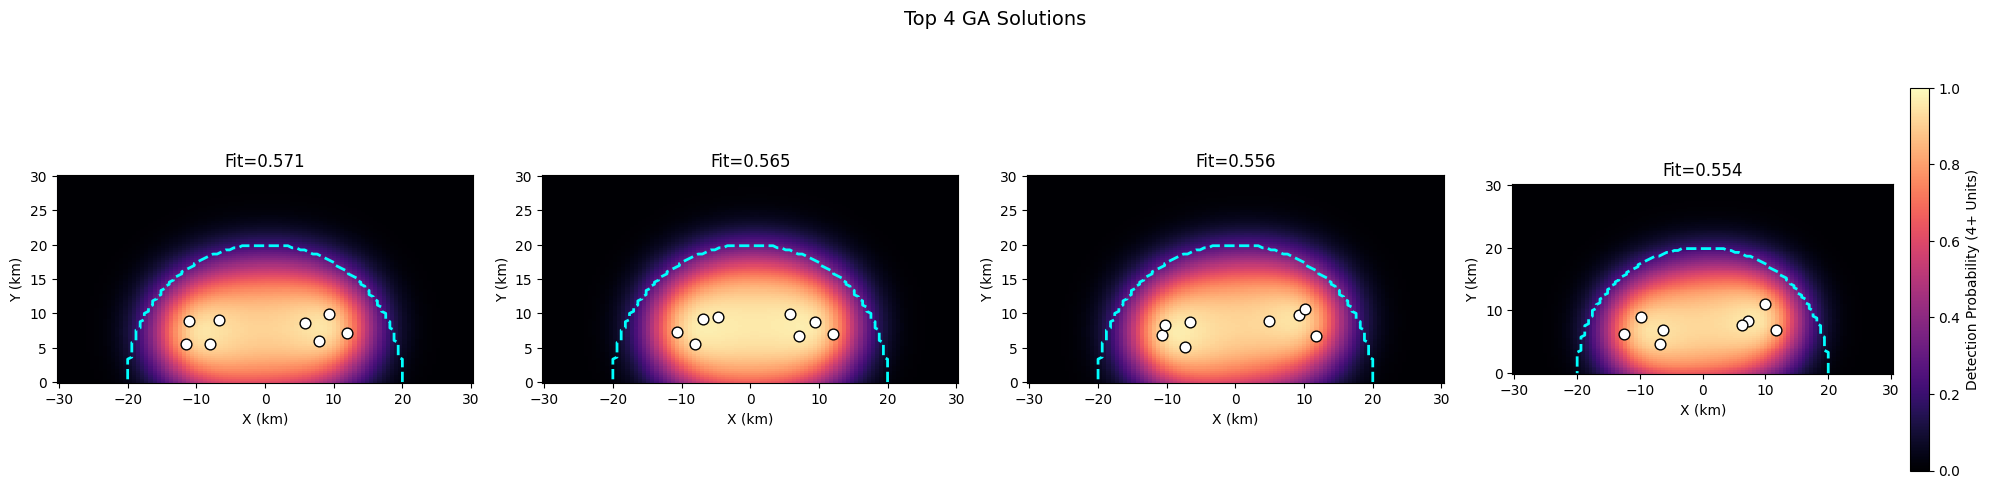


GENETIC ALGORITHM: Custom Bowhead Polygon (4+ Units)
Gen 01 | Mean=0.6348 | Best=0.9917
Gen 02 | Mean=0.9264 | Best=0.9785
Gen 03 | Mean=0.9668 | Best=0.9779
Gen 04 | Mean=0.9696 | Best=0.9771
Gen 05 | Mean=0.9667 | Best=0.9739
Gen 06 | Mean=0.9625 | Best=0.9690
Gen 07 | Mean=0.9606 | Best=0.9676
Gen 08 | Mean=0.9577 | Best=0.9647
Gen 09 | Mean=0.9553 | Best=0.9614
Gen 10 | Mean=0.9518 | Best=0.9595
Gen 11 | Mean=0.9494 | Best=0.9567
Gen 12 | Mean=0.9493 | Best=0.9568
Gen 13 | Mean=0.9474 | Best=0.9552
Gen 14 | Mean=0.9460 | Best=0.9529
Gen 15 | Mean=0.9461 | Best=0.9565
Gen 16 | Mean=0.9424 | Best=0.9543
Gen 17 | Mean=0.9435 | Best=0.9521
Gen 18 | Mean=0.9449 | Best=0.9521
Gen 19 | Mean=0.9436 | Best=0.9502
Gen 20 | Mean=0.9436 | Best=0.9512
Gen 21 | Mean=0.9424 | Best=0.9504
Gen 22 | Mean=0.9431 | Best=0.9518
Gen 23 | Mean=0.9427 | Best=0.9510
Gen 24 | Mean=0.9435 | Best=0.9499
Gen 25 | Mean=0.9430 | Best=0.9497
Gen 26 | Mean=0.9405 | Best=0.9496
Gen 27 | Mean=0.9423 | Best=0.9485
G

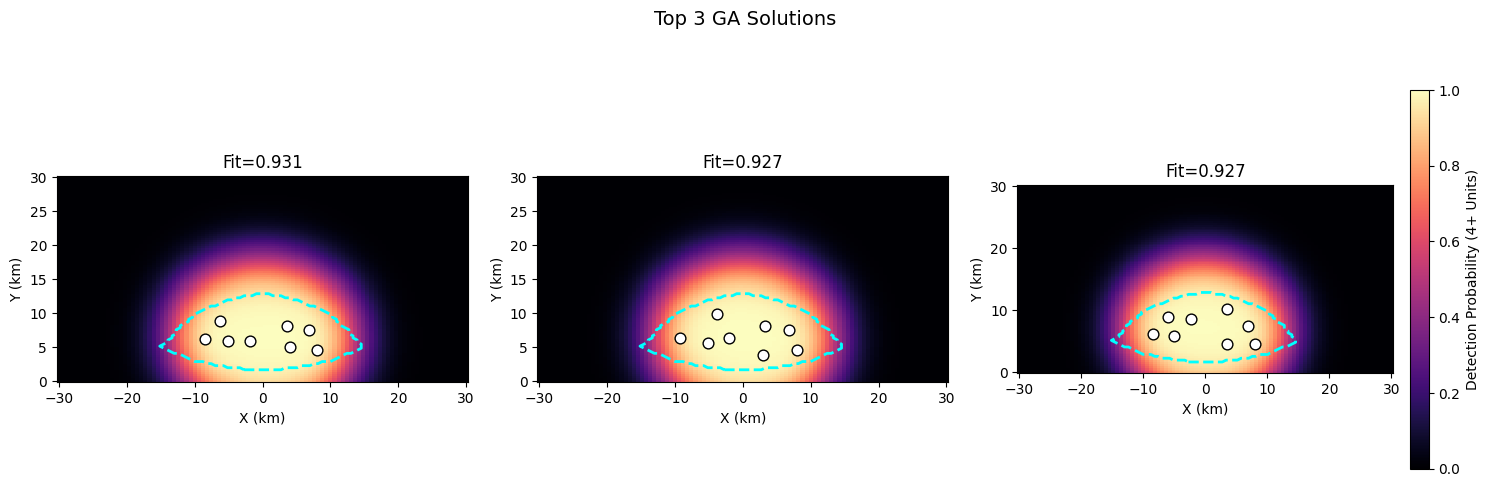

In [ ]:
def execute_fixed_array(geometry="square", radius=20.0):
    """Execute with fixed array geometry."""
    xs, ys = make_array(geometry, spacing=5.0, offset=4.0)

    xlim, ylim = (-30, 30), (0, 30)
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)
    sd = 10.0
    det_func = lambda d: half_normal(d, sd)

    # Create semicircle mask
    mask = semicircle_mask(grid_x, grid_y, radius)

    distances = compute_distances(xs, ys, grid_x, grid_y)
    probs = calculate_probs(det_func, distances)
    four_plus = detection_probabilities(probs)

    mean_prob = mean_probability_in_mask(four_plus, mask)
    print(f"[{geometry}] Mean probability (4+ units, r={radius} km): {mean_prob:.3f}")

    plot_probability_map(grid_x, grid_y, four_plus, xs, ys, mask, title=f"{geometry.capitalize()} Array (4+ Units)")

if __name__ == "__main__":
    # Grid definition
    xlim, ylim = (-30, 30), (0, 30)
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)

    # Detection function
    sd = 10.0
    det_func = lambda d: half_normal(d, sd)

    print("=" * 70)
    print("COMPARISON: Fixed Array Geometries")
    print("=" * 70)
    execute_fixed_array("square", radius=20.0)
    execute_fixed_array("triangular", radius=20.0)
    execute_fixed_array("line", radius=20.0)

    print("\n" + "=" * 70)
    print("GENETIC ALGORITHM: Semicircle Mask (4+ Units)")
    print("=" * 70)
    mask_semicircle = semicircle_mask(grid_x, grid_y, radius=20.0)
    env1 = Environment(
        grid_x, grid_y, det_func, mask_semicircle,
        generations=100, num_recorders=8, metric='mean',
        empty_penalty_fraction=1.0, mutation_rate=0.5,
        alpha_curve='linear',
        detection_probabilities_func=detection_probabilities,
        detection_probabilities_helper_func=detection_probabilities_single
    )
    best1, scores1 = env1.run(k_top=4, save_plots=False)

    print("\n" + "=" * 70)
    print("GENETIC ALGORITHM: Custom Bowhead Polygon (4+ Units)")
    print("=" * 70)
    bowhead_vertices = [
        (-15.0, 5.0), (-10.0, 10.0), (-5.0, 12.0), (0.0, 13.0),
        (5.0, 12.0), (10.0, 10.0), (15.0, 5.0), (10.0, 3.0),
        (5.0, 2.0), (0.0, 1.5), (-5.0, 2.0), (-10.0, 3.0),
    ]
    mask_bowhead = create_custom_shape_mask(grid_x, grid_y, bowhead_vertices)
    env2 = Environment(
        grid_x, grid_y, det_func, mask_bowhead,
        generations=100, num_recorders=8, metric='mean',
        mutation_rate=0.3, alpha_curve='expo'
    )
    best2, scores2 = env2.run(k_top=3)